In [1]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import argparse
import json
from logging.config import dictConfig
from logging import getLogger
import os
import time
from google.colab import files

In [4]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)
print(input.shape, h0.shape, output.shape, hn.shape)

torch.Size([5, 3, 10]) torch.Size([2, 3, 20]) torch.Size([5, 3, 20]) torch.Size([2, 3, 20])


In [9]:
i = 10
h = 20
l = 2
rnn = nn.LSTM(i, h, l)
input = torch.randn(5, 3, i)
h0 = torch.randn(l, 3, h)
c0 = torch.randn(l, 3, h)
output, (hn, cn) = rnn(input, (h0, c0))
print(output.shape, hn.shape, cn.shape)

torch.Size([5, 3, 20]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])


In [64]:
i = 1
h = 1
l = 2
rnn = nn.LSTM(i, h, l)
seq = 1
input = torch.randn(seq, 1, i)
output, _ = rnn(input, None)

optimizer = optim.SGD(rnn.parameters(), lr=0.001)

for epoch in range(10000):
  h, c = None, None
  output = input
  optimizer.zero_grad()
  # log = []
  for i in range(8):
    p = None if h == None else (h, c)
    output, (h, c) = rnn(output, p)
    # log.append(output.item())
    label = torch.tensor([1, 0, 1, 1, 0, 0, 1, 1], dtype=float, requires_grad=True)
    loss = torch.sum(torch.abs(output.view(1) - label[i]))
    loss.backward(retain_graph=True)

  optimizer.step()
  print("\rloss:%s" % loss.item(), end="")

h, c = None, None
log = []
for i in range(8):
    p = None if h == None else (h, c)
    output, (h, c) = rnn(input, p)
    log.append(output.item())
    
log

loss:0.027635693550109863

[0.612765908241272,
 0.8636173009872437,
 0.9359193444252014,
 0.9565600156784058,
 0.9632701277732849,
 0.9658091068267822,
 0.9669104218482971,
 0.9674465656280518]

In [ ]:
i = 1
h = 1
l = 2
rnn = nn.LSTM(i, h, l)
seq = 1
input = torch.randn(seq, 1, i)
output, _ = rnn(input, None)

optimizer = optim.SGD(rnn.parameters(), lr=0.001)

for epoch in range(10000):
  h, c = None, None
  output = input
  optimizer.zero_grad()
  # log = []
  for i in range(8):
    p = None if h == None else (h, c)
    output, (h, c) = rnn(output, p)
    # log.append(output.item())
    label = torch.tensor([1, 0, 1, 1, 0, 0, 1, 1], dtype=float, requires_grad=True)
    loss = torch.sum(torch.abs(output.view(1) - label[i]))
    loss.backward(retain_graph=True)

  optimizer.step()
  print("\rloss:%s" % loss.item(), end="")


In [ ]:
i = 4
h = 4
o = 4
seq = 1
b = 1
rnn = Predictor(i, h, o)
input = torch.tensor([1, 0, 0, 1]).view(1, 4).float()
# output(seq, b, dir*h) ooo (seq, b, o)
label = torch.tensor([1, 1, 0, 0]).view(seq, b, i).float()
# output, _ = rnn(input, None)
criterion = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)
for e in range(100000):
  label = Variable(label)
  input = Variable(input)
  optimizer.zero_grad()
  # h = torch.zero(10,)
  output, _ = rnn(input)
  loss = criterion(output, label)
  loss.backward()
  optimizer.step()
  # print("\r", end="")
  # print(output, end="/")
  # print(output)
  print("\r(%s, %s), loss:%s" % (output[0][0].item(), output[0][2].item(), loss.item()), end="")

In [88]:
class Predictor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Predictor, self).__init__()
        # self.rnn = nn.RNN(n_input, n_hidden, num_layers=1, batch_first=True)
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers=1, batch_first=True)
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x, h=None, c=None):
        # output, hp = self.rnn(x.unsqueeze(1), h)
        output, (hp, cp) = self.lstm(x.unsqueeze(1), (h, c))
        output = self.out(output.squeeze(1))
        return output, (hp, cp)

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline


In [98]:
np.random.seed(0)
data_num = 2000
test_data_num = 100
min_length = 2
max_length = 100
fixed_length = 100
min_num = 0
max_num = 3

In [99]:
def generate_data(n):
    x_data = []
    y_data = []
    for i in range(n):
        length = np.random.randint(min_length, max_length + 1)
        dt = np.zeros(fixed_length)
        dt[:length] = np.random.randint(min_num, max_num + 1, size=length)
        x_data.append(list(dt))
        y_data.append(sum(dt))
    
    # for PyTorch
    x_data = torch.from_numpy(np.array(x_data)).float()
    y_data = torch.from_numpy(np.array(y_data)).float().view(-1, 1)
    return x_data, y_data

In [100]:
X_train, y_train = generate_data(data_num)
train = data.TensorDataset(X_train, y_train)
train_loader = data.DataLoader(train, batch_size=50, shuffle=True)


In [105]:
model = Predictor(fixed_length, 64, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [106]:
n_epoch = 100
lloss = []
for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        bX, by = data
        bX, by = Variable(bX), Variable(by)
        optimizer.zero_grad()
        print(bX.shape)
        print(bX.unsqueeze(1).shape)
        output, _ = model(bX)
        print(output.shape)
        loss = criterion(output, by)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    lloss.append(running_loss)

  2%|▏         | 2/100 [00:00<00:07, 13.13it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

  4%|▍         | 4/100 [00:00<00:07, 13.42it/s]


torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 

  8%|▊         | 8/100 [00:00<00:06, 13.89it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 10%|█         | 10/100 [00:00<00:06, 14.02it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 14%|█▍        | 14/100 [00:00<00:06, 14.08it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 16%|█▌        | 16/100 [00:01<00:05, 14.12it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 20%|██        | 20/100 [00:01<00:05, 14.20it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 22%|██▏       | 22/100 [00:01<00:05, 14.07it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 24%|██▍       | 24/100 [00:01<00:05, 14.08it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 28%|██▊       | 28/100 [00:01<00:05, 14.10it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 30%|███       | 30/100 [00:02<00:04, 14.14it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 34%|███▍      | 34/100 [00:02<00:04, 14.29it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 36%|███▌      | 36/100 [00:02<00:04, 14.06it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 40%|████      | 40/100 [00:02<00:04, 14.04it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 42%|████▏     | 42/100 [00:02<00:04, 13.90it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 46%|████▌     | 46/100 [00:03<00:03, 14.08it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 48%|████▊     | 48/100 [00:03<00:03, 13.90it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 50%|█████     | 50/100 [00:03<00:03, 13.66it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 54%|█████▍    | 54/100 [00:03<00:03, 13.92it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 56%|█████▌    | 56/100 [00:04<00:03, 13.64it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 60%|██████    | 60/100 [00:04<00:02, 14.04it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 62%|██████▏   | 62/100 [00:04<00:02, 13.98it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 66%|██████▌   | 66/100 [00:04<00:02, 14.13it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 68%|██████▊   | 68/100 [00:04<00:02, 13.99it/s]


torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 

 72%|███████▏  | 72/100 [00:05<00:01, 14.36it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 74%|███████▍  | 74/100 [00:05<00:01, 14.23it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 76%|███████▌  | 76/100 [00:05<00:01, 14.26it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 80%|████████  | 80/100 [00:05<00:01, 14.23it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 82%|████████▏ | 82/100 [00:05<00:01, 14.07it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 86%|████████▌ | 86/100 [00:06<00:00, 14.48it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 88%|████████▊ | 88/100 [00:06<00:00, 14.38it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 92%|█████████▏| 92/100 [00:06<00:00, 14.52it/s]

torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 1

 94%|█████████▍| 94/100 [00:06<00:00, 14.44it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

 98%|█████████▊| 98/100 [00:06<00:00, 14.05it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

100%|██████████| 100/100 [00:07<00:00, 14.08it/s]

torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50, 1])
torch.Size([50, 100])
torch.Size([50, 1, 100])
torch.Size([50,

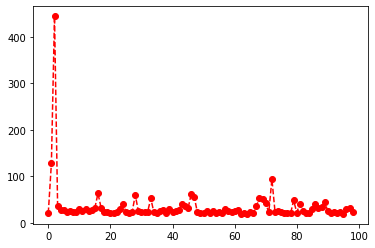

In [34]:
plt.plot(lloss[1:100], "ro--")

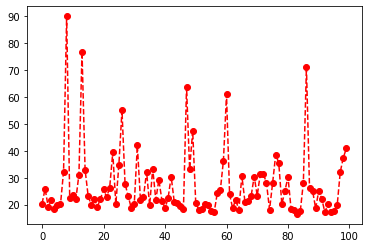

In [37]:
plt.plot(lloss, "ro--")